In [1]:
import torch  # основная библиотека PyTorch для работы с нейронными сетями
import torchvision  # библиотека для работы с изображениями
from torchvision import transforms  # модуль для преобразования изображений
from torch.utils.data import DataLoader  # загрузчик данных
from torchvision.datasets import ImageFolder  # модуль для работы с папками изображений

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  

# импорт метрик оценки из sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import label_binarize

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),          
    transforms.Normalize(           
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
data_dir = 'train'  
dataset = ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
print(f"Количество классов: {len(dataset.classes)}")
print(f"Названия классов: {dataset.classes}")
print(f"Всего изображений: {len(dataset)}")

Количество классов: 3
Названия классов: ['paper', 'rock', 'scissors']
Всего изображений: 2520


In [5]:
model = torchvision.models.resnet50(weights='IMAGENET1K_V2')

# Заменяем последний слой на новый с нужным количеством классов
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/vad/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [7]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [8]:
predictions, true_labels, probabilities = evaluate_model(model, dataloader)

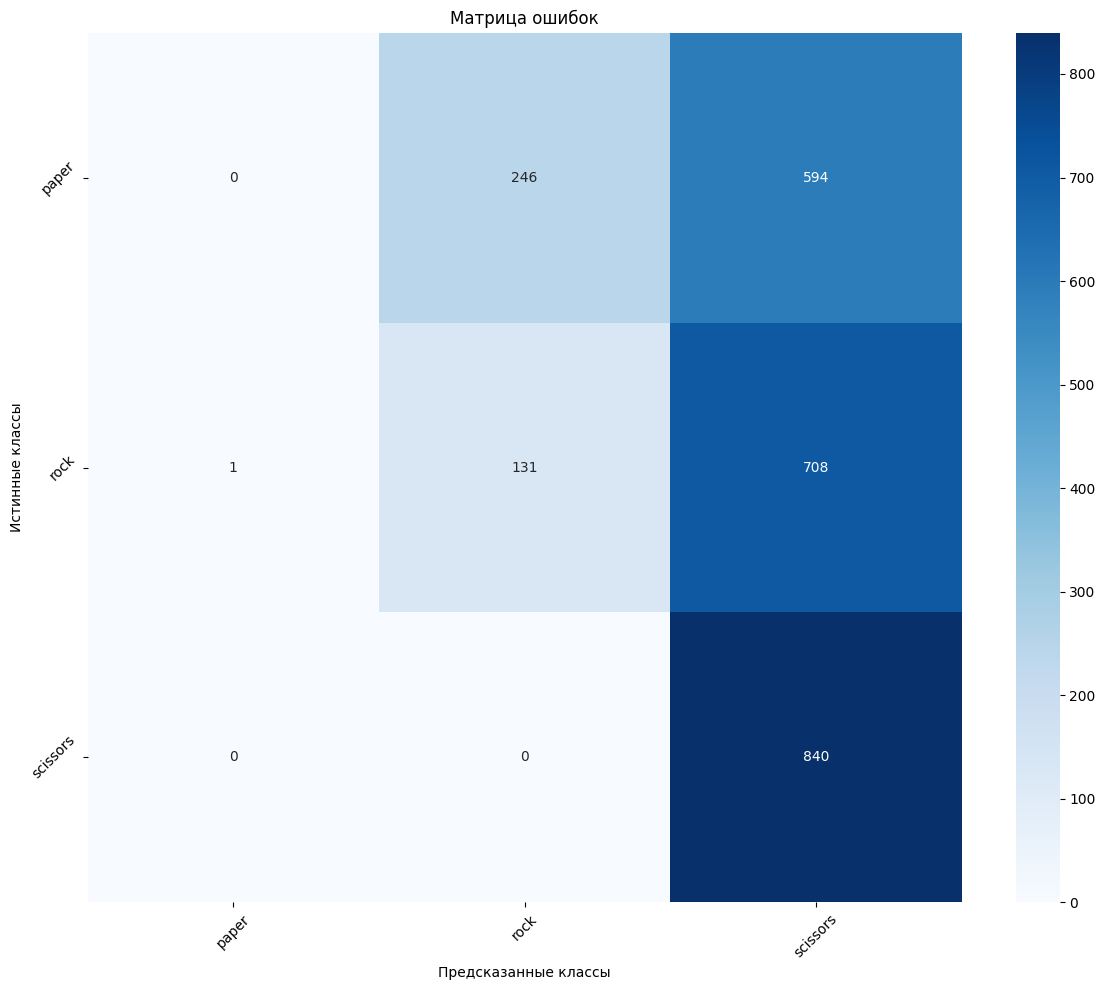

In [9]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
print("\nОтчет о классификации:")
print(classification_report(true_labels, predictions, 
                          target_names=dataset.classes))


Отчет о классификации:
              precision    recall  f1-score   support

       paper       0.00      0.00      0.00       840
        rock       0.35      0.16      0.22       840
    scissors       0.39      1.00      0.56       840

    accuracy                           0.39      2520
   macro avg       0.25      0.39      0.26      2520
weighted avg       0.25      0.39      0.26      2520



In [11]:
accuracy = accuracy_score(true_labels, predictions)
print(f"\nОбщая точность: {accuracy:.4f}")


Общая точность: 0.3853


In [16]:
def show_predictions(model, dataloader, num_images=5):

    model.eval()
    

    images, labels = next(iter(dataloader))
    

    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    images = images.cpu()
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std[:, None, None] + mean[:, None, None]
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        

        true_label = dataset.classes[labels[i]]
        pred_label = dataset.classes[predicted[i].cpu()]
        
        ax.imshow(img)
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f'True: {true_label}\nPred: {pred_label}', 
                    color=color, fontsize=10)
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

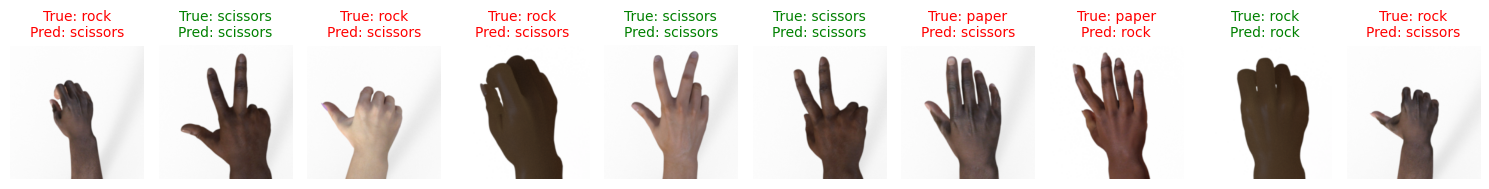

In [15]:
show_predictions(model, dataloader, num_images=10)

In [17]:
new_model = torchvision.models.resnet101(weights='IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /home/vad/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100.0%


In [18]:
new_model.fc = torch.nn.Linear(new_model.fc.in_features, len(dataset.classes))

In [19]:
predictions, true_labels, probabilities = evaluate_model(new_model, dataloader)

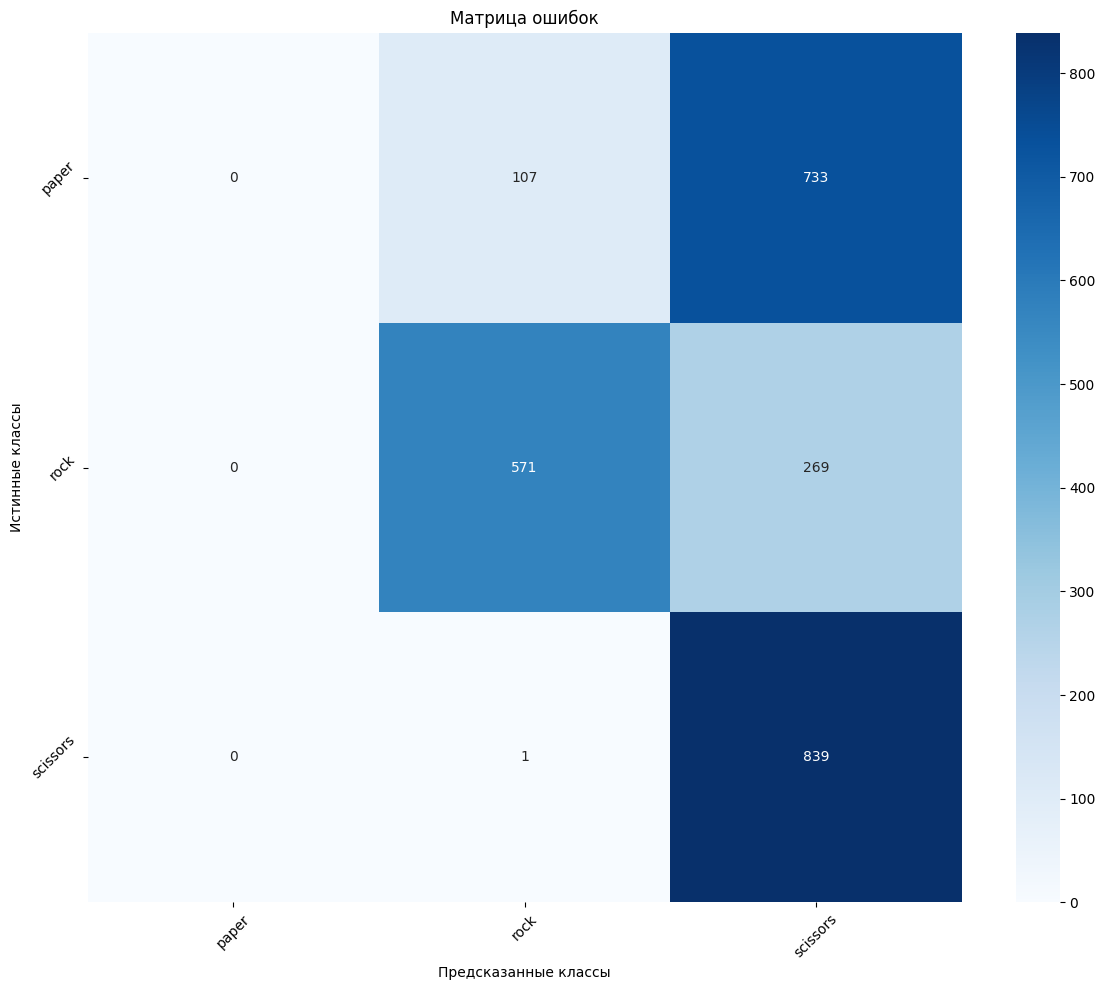

In [20]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
print("\nОтчет о классификации:")
print(classification_report(true_labels, predictions, 
                          target_names=dataset.classes))


Отчет о классификации:
              precision    recall  f1-score   support

       paper       0.00      0.00      0.00       840
        rock       0.84      0.68      0.75       840
    scissors       0.46      1.00      0.63       840

    accuracy                           0.56      2520
   macro avg       0.43      0.56      0.46      2520
weighted avg       0.43      0.56      0.46      2520



/home/vad/PycharmProjects/jupyter_notebook/class/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vad/PycharmProjects/jupyter_notebook/class/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vad/PycharmProjects/jupyter_notebook/class/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [22]:
accuracy = accuracy_score(true_labels, predictions)
print(f"\nОбщая точность: {accuracy:.4f}")


Общая точность: 0.5595


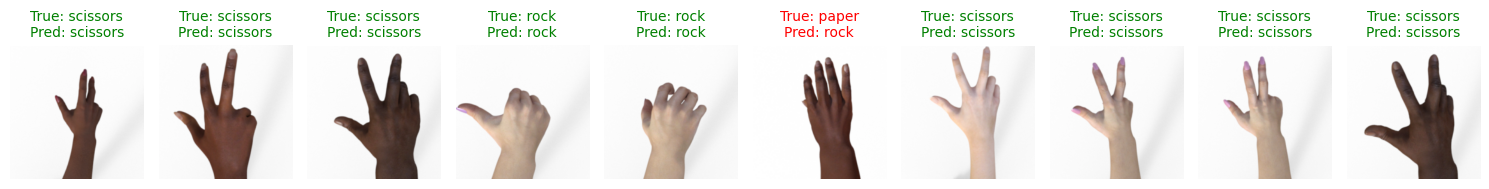

In [23]:
show_predictions(new_model, dataloader, num_images=10)